# Chapter 6. Training State of Art Model

We will be using more advanced techniques to train an image classifier modek and get state of art results. 

We will discuss about:
- A powerful data augmentation technique - mixup
- procgressive resizing approach
- test time augmentation

We wont be using pre-trained models, we will be training a model from scrath (not using transfer-learning) using subset of ImageNet - Imagenette. 
Imagenette characterstics:
- 10 classes
- Can be used on low resource machines
- Can be helpful to test algos quickly and cheaply

When working in real-time env, keep following things in mind:

* **Understand Your Data:** Explore data types, distributions, and potential variations before analysis.
* **Sample Smartly:** Use techniques like stratified sampling to capture key characteristics with less data.
* **Chunk for Experiments:** Break down the data stream into manageable chunks for focused analysis.
* **Prioritize Visualization:** Leverage real-time visualizations to identify trends and anomalies quickly.


In [16]:
from fastai.vision.all import *
path = untar_data(URLs.IMAGENETTE)


In [8]:

dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(460),
                   batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = dblock.dataloaders(path, bs=64)

Could not do one pass in your dataloader, there is something wrong in it. Please see the stack trace below:


NotImplementedError: The operator 'aten::_linalg_solve_ex.result' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

In [ ]:
print(dls.c)

In [ ]:
model = xresnet50(n_out = dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics = accuracy)
learn.fit_one_cycle(5, 3e-3)

We can see the reusults obtained, its a good baseline. We will improve the performance now. 

While training the model from scratch, we need to follow some traditional techniques that are important. We will go through them oneby one.

### 1. Normalization

Normalization is a technique used to standardize the range of features of data and often applied as part of data preparation for machine learning. The goal of normalization is to change the values of numeric columns in the dataset to use a common scale, without distorting differences in the ranges of values or losing information. Normalization is also required for some algorithms to model the data correctly.

Normalization can be useful when your data has varying scales and the algorithm you are using does not make assumptions about the distribution of your data, such as k-nearest neighbors and artificial neural networks.

In cases of images- The data should have a mean of zero, and standard deviation of 1. But most of the image and cimputer vision libarries will use values between 0 and 255 for pixels, or between 0 and 1. in either case, the data wont be having the mean of 0 and SD of 1. 


In [11]:
x,y = dls.one_batch()
x.mean(dim = [0,2,3]), x.std(dim = [0,2,3])


NameError: name 'dls' is not defined

- Data normalization is important for improving deep learning model performance.
- Fastai's Normalize transform allows easy data normalization within mini-batches.
- You can use pre-defined imagenet_stats (mean and standard deviation) for ImageNet-like datasets.
- Fastai can calculate statistics from a single batch (not ideal) if none are provided.
Lets add this transform (using `imagenet_stats`as Imagenette which is a subset of ImageNet):

In [13]:
def get_dls(bs, size):
    dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                       get_items = get_image_files,
                       get_y = parent_label,
                       item_tfms = Resize(460),
                       batch_tfms = [*aug_transforms(size=size, min_scale=0.75),
                                     Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(path, bs = bs)


dls = get_dls(64,124)
x,y = dls.one_batch()
x.mean(dim = [0,2,3]), x.std(dim = [0,2,3])

Could not do one pass in your dataloader, there is something wrong in it. Please see the stack trace below:


NotImplementedError: The operator 'aten::_linalg_solve_ex.result' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

Lets see what effect did it had on the training our model.

In [12]:
model = xresnet50(n_out = dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics = accuracy)
learn.fit_one_cycle(5, 3e-3)

NameError: name 'dls' is not defined

We see, Normalization didn't help us more here, but normalization becomes very important when using pre-trained models. This is because we have to align our data so that the pre-trained model can understand better. Suppose the pretrained model was trained on data with the range (0,1) so we need to convert our data in the similar manner.

Previously, when we used pretained model `vision_learner` the fastai library automatically adds `Normalize` transform. 

Trainings till now has been done at size 224. We could have begun training at a smaller size before going to that, this is called *progressive resizing*.


### Pregressive Resizing


* Trains a model on images of increasing sizes sequentially.
* Improves model performance and generalization on unseen data.
* Applicable to various tasks like image classification, object detection, and segmentation.

**Benefits:**

* **Learning from Different Scales:** The model learns features at various scales, making it more robust to variations in image size.
* **Transfer Learning Analogy:** Similar to transfer learning, adapting to a larger size leverages the previous knowledge while learning new details.
* **Improved Generalization:** By training on different sizes, the model becomes less sensitive to specific image dimensions, leading to better performance on unseen data.

**Implementation Steps:**

1. **`get_dls` Function:** Define a function `get_dls(image_size, batch_size)` that takes the desired image size and batch size as inputs and returns the corresponding `DataLoaders` object.
2. **Start Small, Train Progressively:** 
    * Use `get_dls` to create `DataLoaders` with a small image size.
    * Train the model for a few epochs using `fit_one_cycle` or your preferred training method.
3. **Increase Size, Fine-tune (Optional):**
    * Increase the image size using `get_dls` and create new `DataLoaders`.
    * Consider using fine-tuning techniques like freezing earlier layers to leverage the learned features while adapting to the larger size.

**Additional Considerations:**

* **Number of Stages and Epochs:** Experiment with the number of resizing stages and training epochs per stage to find the optimal configuration for your dataset and model.
* **Learning Rate Adjustments:** You might need to adjust the learning rate as you increase the image size to ensure proper convergence.

By incorporating progressive resizing into your training pipeline, you can potentially enhance the performance and generalizability of your deep learning models for various computer vision tasks.


In [ ]:
dls = get_dls(128,128)
learn = Learner(dls, xresnet50(n_out = dls.c), loss_func=CrossEntropyLossFlat(), metrics = accuracy)
learn.fit_one_cycle(5, 3e-3)

In [ ]:
# we can replace the DataLoaders inside the Learner and fine-tune. 

learn.dls = get_dls(64,224)
learn.fine_tune(5, 3e-3) 

So, we observe:

* Improved performance compared to training on a single image size.
* Faster initial training due to smaller image sizes.
* Scalable: Applicable to various image sizes up to the original data size.

**Limitations:**

* No benefit for images larger than the original data.
* Potential harm for transfer learning if the pre-trained model and target task are very similar (ie. the pretrained model has already been trained on images size of our interest). In this case, when we train the model on smaller images, the pretrained weights can get damaged. 

**Recommendation:**

* Experimentation is key: Try progressive resizing to see if it improves performance for your specific task.

**Next Steps:**

* Explore data augmentation for the validation set to potentially improve generalization. 
* Till now we have only applied to the training set, we can do the same for validation set. 
* We can make prediction for few augmented versions of validation set and average them.


### Test Time Augmentation

**Key Concepts:**

1. **Data Augmentation**:
   - Technique to enhance the training dataset with transformations like random cropping.
   - Improves model generalization and reduces the need for extensive training data.

2. **Random Cropping**:
   - Applied to training data for augmentation.
   - fastai uses center cropping for validation: selecting the largest square area in the image center.

3. **Problems with Center Cropping**:
   - Small objects or critical features near image edges may be cropped out.
   - This can lead to incorrect predictions, especially in multi-label datasets or specific classification tasks (e.g., pet breed classification).

4. **Alternative to Center Cropping**:
   - **Avoid Random Cropping**: Squish or stretch images to fit a square space, which can distort images and make recognition harder.
   - **Test Time Augmentation (TTA)**: Instead of center cropping, crop multiple areas of the image, augment them, and take the average or maximum of predictions.

5. **Test Time Augmentation (TTA)**:
   - **Definition**: During inference or validation, create multiple versions of each image using data augmentation. Combine predictions from these versions by averaging or taking the maximum.
   - **Benefits**: Can significantly improve accuracy without increasing training time.
   - **Trade-offs**: Increases validation/inference time proportional to the number of augmented images used.

6. **Implementation in fastai**:
   - By default, fastai uses the unaugmented center crop image plus four randomly augmented images for TTA.

**In short:**

- **Test Time Augmentation (TTA)**: A technique used during inference or validation that involves creating multiple augmented versions of each image and aggregating their predictions.

#### Conclusion:

- **Purpose**: Enhance model accuracy and robustness during validation and inference.
- **Mechanism**: Generate multiple augmented versions of an image and combine their predictions.
- **Advantages**: Significant accuracy improvement, no extra training time.
- **Disadvantages**: Increased validation/inference time.

By understanding and applying TTA, one can leverage the power of data augmentation even during the validation and inference phases, potentially achieving better model performance and more reliable predictions.


In [14]:
# passing DataLoader to fastai's tta method - by default it uses validation set

pred, targs = learn.tta()
accuracy(pred,targs).item()


NameError: name 'learn' is not defined

We can see, TTA gives boost in the perfomance, without any additional training required. but it makes inferencing slower, because we are averaging 5 images for TTA. 

Lets discuss image augmentation technique - mixup.

### Mixup Data Augmentation Technique

#### Overview
- **Mixup** is a data augmentation technique introduced in the 2017 paper "[mixup: Beyond Empirical Risk Minimization](https://arxiv.org/abs/1710.09412)" by Hongyi Zhang et al.
- It significantly improves model accuracy, especially when:
  - Limited data is available.
  - There's no pretrained model trained on similar data.

#### Key Concepts
- **Data Augmentation**: Enhances generalization of models but is often dataset-dependent.
  - Common methods include flipping images (horizontally or vertically).
  - The effectiveness of each method varies with the dataset.

- **Adjustable Augmentation**: 
  - Important to have techniques that allow adjustment of the augmentation degree.
  - This flexibility helps in determining the optimal level of augmentation for a specific dataset.

#### How Mixup Works
1. **Random Selection**: For each image in the dataset:
   - Select another image at random.
   - Pick a random weight between 0.5 and 1.0.

2. **Weighted Average**:
   - Compute the weighted average of the selected image and the original image. This forms the new image (independent variable).
   - Similarly, compute the weighted average of their labels to form the new label (dependent variable).

#### Pseudocode Explanation
- **Variables**:
  - `image1`, `target1`: Original image and its label.
  - `image2`, `target2`: Randomly selected image and its label.
  - `t`: Random weight between 0.5 and 1.0.

```python
# Pseudocode
image2, target2 = dataset[randint(0, len(dataset))]
t = random_float(0.5, 1.0)
new_image = t * image1 + (1 - t) * image2
new_target = t * target1 + (1 - t) * target2
```

#### Requirements
- **One-Hot Encoding**: 
  - Targets (labels) need to be one-hot encoded for Mixup to work effectively.
- **Consistency**:
  - The same weight `t` is used for both image and label blending.

#### Benefits
- **Improved Generalization**: Enhances model performance by creating more varied training samples.
- **Flexibility**: Ability to adjust the degree of augmentation to optimize results.

#### Conclusion
- Mixup is a robust data augmentation technique that leverages the creation of synthetic samples through weighted averages, enhancing model accuracy and generalization, particularly in scenarios with limited data.

These notes capture the essence of the Mixup technique, emphasizing its implementation, benefits, and requirements.
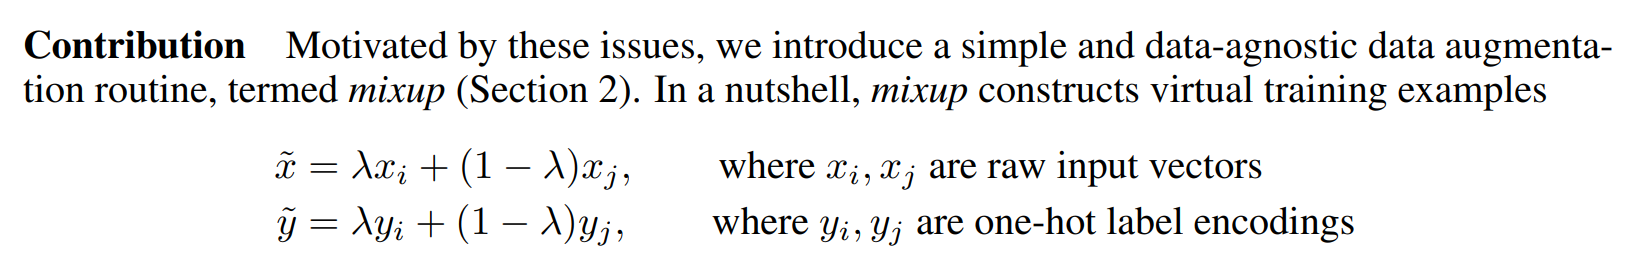

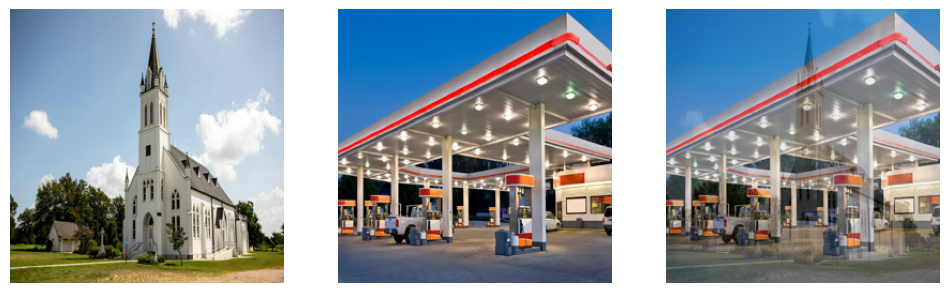

In [22]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch
from torchvision.transforms import ToTensor

# Instantiate ToTensor correctly
to_tensor = ToTensor()

# Fetch images
r1 = requests.get("https://img.texasmonthly.com/2023/07/texas-painted-churches-1.jpg?auto=compress&crop=faces&fit=fit&fm=pjpg&ixlib=php-3.3.1&q=45")
r2 = requests.get("https://cdn.sanity.io/images/zlfgolrr/production/8a355ef8f25011e46cfc96e360e738ee0c323266-724x482.jpg?w=724&h=482&auto=format")

# Open images
church = Image.open(BytesIO(r1.content))
gas = Image.open(BytesIO(r2.content))

# Resize images
church = church.resize((256, 256))
gas = gas.resize((256, 256))

# Convert images to tensors and normalize
tchurch = to_tensor(church).float()
tgas = to_tensor(gas).float()

# Display images
_, axs = plt.subplots(1, 3, figsize=(12, 4))

def show_image(img, ax=None):
    img = make_grid(img.unsqueeze(0), nrow=1, padding=0).permute(1, 2, 0)
    if ax is None:
        ax = plt.gca()
    ax.imshow(img.numpy())
    ax.axis('off')
    return ax

show_image(tchurch, ax=axs[0])
show_image(tgas, ax=axs[1])
show_image(0.3 * tchurch + 0.7 * tgas, ax=axs[2])

plt.show()


We can see the images have been overlapped up in the third image.

- **Mixup**: A data augmentation technique where a new image is created by combining two images with a weighted average.
  - Example: `Image3 = 0.3 * Image1 + 0.7 * Image2`
  - Corresponding labels: `Label3 = 0.3 * Label1 + 0.7 * Label2`

#### One-Hot Encoding and Linear Combination of Targets
- **One-Hot Encoding**: Representing categorical labels as binary vectors.
  - Example for "church" (index 2) and "gas station" (index 7) in a 10-class problem:
    - Church: `[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]`
    - Gas Station: `[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]`
  - Mixed Label: `[0, 0, 0.3, 0, 0, 0, 0, 0.7, 0, 0]` (target)

#### Implementation with Fastai
- **Fastai**: Utilizes callbacks for custom behaviors during training.
  - **Callbacks**: Inject custom training behaviors (e.g., learning rate schedules, mixed precision training).
  - **MixUp Callback**: Automates Mixup during training.
  - Example training setup with Mixup:
    ```python
    model = xresnet50(n_out=dls.c)
    learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), 
                    metrics=accuracy, cbs=MixUp())
    learn.fit_one_cycle(5, 3e-3)
    ```

#### Effects of Mixup on Training
- **Challenges**:
  - Harder to train due to mixed images and dual-label prediction.
  - Requires more epochs to achieve better accuracy.
- **Benefits**:
  - Reduces overfitting by providing varied data each epoch.
  - Effective for long training sessions (e.g., >80 epochs).

#### Mixup Beyond Image Data
- **Versatility**:
  - Applicable to various data types, including NLP.
  - Can be used on activations within models, not just inputs.

#### Addressing Label Issues with Mixup
- **Softmax and Sigmoid Outputs**:
  - These functions produce outputs never exactly 0 or 1, leading to extreme activations over many epochs.
- **Mixup Solution**:
  - Labels become linear combinations (e.g., 0.7, 0.3), mitigating the issue of extreme activations.
- **Potential Issue**:
  - Mixup changes label values implicitly, which may require adjusting the amount of Mixup for desired label distribution.

#### Label Smoothing as an Alternative
- **Label Smoothing**:
  - A technique to directly control label values, ensuring they are not strictly 0 or 1.
  - Provides a more explicit way to manage label values compared to Mixup.

### Summary
- Mixup is a powerful data augmentation technique that combines images and labels, reducing overfitting and providing varied training data.
- It is implemented in fastai using callbacks, particularly beneficial for long training sessions.
- Mixup can be applied beyond images, useful for various data types and even within model activations.
- Label smoothing is an alternative to Mixup for controlling label values explicitly.

---

In [23]:
model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy, cbs=MixUp).to_fp16()
learn.fit_one_cycle(15, 3e-3)

NameError: name 'dls' is not defined

### Label Smoothing
**Paper:**
- https://arxiv.org/abs/1512.00567


**Problem:**

* During training, models are typically trained with one-hot encoded labels (all 0s except for a 1 in the correct class position). 
* This encourages the model to be overly confident in its predictions, even for classes it's unsure about.

**Impact:**

* Overfitting: The model performs well on the training data but struggles on unseen data.
* Sensitivity to Mislabeled Data: Incorrect labels can significantly impact the model's performance.

**Solution: Label Smoothing**

* Replaces one-hot encoded labels with "softer" labels.
* Uses a small value `epsilon` (usually 0.1) to distribute probability mass (uncertainty) across all classes.
* Encourages the model to be less confident in its predictions, improving generalization.

**Benefits:**

* More robust training, especially with potentially mislabeled data.
* Improved model generalizability.

**Implementation:**

* Not necessary to perform one-hot encoding in practice.
* Libraries like fastai handle label smoothing automatically with a user-defined `epsilon` parameter.

**Example:**

* Imagenette with 10 classes and `epsilon=0.1`:
    * Original one-hot encoded label for class 3: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
    * Label smoothing applied: [0.01, 0.01, 0.01, 0.91, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

**Key Points:**

* Label smoothing introduces a small amount of noise to the labels, making the model more robust to overfitting and mislabeled data.
* It encourages the model to consider all classes during training, leading to better generalization on unseen data.



To use this in practice, we just have to change the loss function in our call to Learner:

```py
model = xresnet50(n_out=dls.c)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), 
                metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)
```
Like with Mixup, you won't generally see significant improvements from label smoothing until you train more epochs. Try it yourself and see: how many epochs do you have to train before label smoothing shows an improvement. 




#### Paper discussion on Label Smoothing from the Paper by Szegedy et al.

**Problem with High Confidence Predictions:**

* The paper highlights limitations when the model assigns very high probability (close to 1) to the correct class (ground-truth label).
* This can lead to overfitting: the model performs well on training data but might not generalize well to unseen data.
* High confidence predictions create large differences between the correct class logit and others.
* Combined with bounded gradients (limited update steps), this hinders the model's ability to adapt during training.

**Explanation:**

* Softmax/Sigmoid functions limit the maximum output value (typically 1).
* Assigning high probability (close to 1) to the correct class (denoted by `z_t`) requires a much larger activation for that class compared to others.
* This creates a situation where the model becomes "too confident" about its predictions, potentially hindering its ability to learn and adapt.

**Benefits of Label Smoothing:**

* The paper suggests that Label Smoothing helps address this issue by introducing "soft labels" during training.
* Soft labels distribute the probability mass across all classes instead of concentrating it solely on the ground-truth class.
* This can potentially improve generalization and the model's ability to adapt, especially in transfer learning scenarios.

**Additional Notes:**

* The text clarifies the meaning of mathematical symbols used in the paper (`ε`, `z_t`).
* It emphasizes the importance of understanding symbol definitions within a research paper.

I hope these notes provide a concise understanding of the reasoning behind Label Smoothing based on the provided excerpt.


In [ ]:
model = xresnet50()
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy).to_fp16()
learn.fit_one_cycle(15, 3e-3)

### Label Smoothing, Progrssive Resizing and Mixup application

In [ ]:
dls = get_dls(128, 128)
model = xresnet50()
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy, cbs=MixUp).to_fp16()
learn.fit_one_cycle(15, 3e-3)

In [ ]:
learn.dls = get_dls(64, 224)
learn.fine_tune(10, 1e-3)

### Conclusion

* You've learned the fundamentals for training computer vision models with Fastai.
* **Experimentation is Key:** Try techniques like Mixup, label smoothing, progressive resizing, and test-time augmentation to improve results and avoid overfitting.
* **Use Smaller Datasets for Prototyping:** If your dataset is large, find a representative subset like Imagenette for initial experimentation.
* **Fastai Applications Beyond Computer Vision:** Upcoming chapters cover collaborative filtering, tabular modeling, and text analysis. 
* **Deeper Dive into ConvNets:** A later section will delve deeper into convolutional neural networks.
